In [1]:
from environment import CoronagraphEnvironment
import hcipy
from hcipy import *
from matplotlib import pyplot as plt
import numpy as np

In [2]:
e = CoronagraphEnvironment(num_modes=10)

initializing coronagraph env. might take a minute.


(57600,)


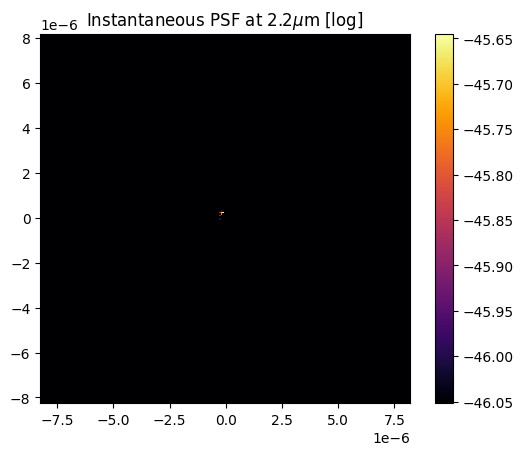

In [30]:
e.set_random_dm(noise=0.01)
plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')

clipped = np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None)

print(clipped.shape)
imshow_field(np.log(clipped), cmap='inferno')
plt.colorbar()
plt.show()

In [29]:
print(e.get_slopes().shape)

(2, 1849)


In [5]:
from tqdm import tqdm

# Build out a training dataset for a traditional CNN encoder.

# Example: Generate a dataset of N random DM settings and their corresponding images
N = 5000  # Number of samples
images = []
dm_settings = []
slopes = []

for _ in tqdm(range(N), desc="Building dataset"):
    e.set_random_dm(noise=0.01)
    images.append(np.log(np.clip(e.get_camera_image(), a_min = 1e-8, a_max = None)))
    dm_settings.append(e.get_perfect_adjustment()) 
    slopes.append(e.get_slopes())

# Normalize dm_settings to zero mean and unit variance
dm_settings = np.array(dm_settings)
dm_mean = dm_settings.mean(axis=0)
dm_std = dm_settings.std(axis=0)
dm_settings_norm = (dm_settings - dm_mean) / (dm_std + 1e-8)

# Normalize slopes to zero mean and unit variance
slopes = np.array(slopes)
slopes_mean = slopes.mean(axis=0)
slopes_std = slopes.std(axis=0)
slopes_norm = (slopes - slopes_mean) / (slopes_std + 1e-8)

Building dataset:   0%|          | 0/5000 [00:00<?, ?it/s]

Building dataset: 100%|██████████| 5000/5000 [09:18<00:00,  8.96it/s]


In [6]:
from sklearn.model_selection import train_test_split

# Convert images (list of OldStyleField) to numpy arrays for ML usage
X = np.array([np.array(slope) for slope in slopes_norm])
y = dm_settings_norm

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
import torch

import torch.nn as nn
import torchvision.models as models

class LargeImageEncoderNet(nn.Module):
    def __init__(self, output_dim=500, input_shape=(3, 224, 224)):
        super(LargeImageEncoderNet, self).__init__()
        h, w = input_shape
        self.encoder = nn.Sequential(
            nn.Linear(h * w, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )       

    def forward(self, x):
        return self.encoder(x)
    
# Example usage:
# model = LargeImageEncoderNet(output_dim=500)
# output = model(torch.randn(1, 3, 224, 224))  # Example input

In [ ]:
# Prepare data for training
import torch.optim as optim

# Flatten X_train if needed (currently shape: (800, 2, 1849))
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize model, loss, and optimizer
model = LargeImageEncoderNet(output_dim=y_train.shape[1], input_shape=(2, 1849))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/500, Loss: 0.5696
Epoch 2/500, Loss: 0.1958
Epoch 3/500, Loss: 0.9580
Epoch 4/500, Loss: 1.7795
Epoch 5/500, Loss: 0.2467
Epoch 6/500, Loss: 0.3021
Epoch 7/500, Loss: 0.3678
Epoch 8/500, Loss: 0.3673
Epoch 9/500, Loss: 0.3297
Epoch 10/500, Loss: 0.2691
Epoch 11/500, Loss: 0.1958
Epoch 12/500, Loss: 0.1255
Epoch 13/500, Loss: 0.0854
Epoch 14/500, Loss: 0.0894
Epoch 15/500, Loss: 0.0895
Epoch 16/500, Loss: 0.0859
Epoch 17/500, Loss: 0.0749
Epoch 18/500, Loss: 0.0443
Epoch 19/500, Loss: 0.0320
Epoch 20/500, Loss: 0.0365
Epoch 21/500, Loss: 0.0387
Epoch 22/500, Loss: 0.0421
Epoch 23/500, Loss: 0.0407
Epoch 24/500, Loss: 0.0275
Epoch 25/500, Loss: 0.0182
Epoch 26/500, Loss: 0.0180
Epoch 27/500, Loss: 0.0197
Epoch 28/500, Loss: 0.0217
Epoch 29/500, Loss: 0.0226
Epoch 30/500, Loss: 0.0171
Epoch 31/500, Loss: 0.0119
Epoch 32/500, Loss: 0.0107
Epoch 33/500, Loss: 0.0098
Epoch 34/500, Loss: 0.0101
Epoch 35/500, Loss: 0.0110
Epoch 36/500, Loss: 0.0107
Epoch 37/500, Loss: 0.0089
Epoch 38/5

In [ ]:
e.get_camera_image().shape # reduce to no more than a few thousand pixels. (FOV or sampling change, maybe both)

(57600,)

In [ ]:
# region of interest starts at 2-3 lambda / D, and ends around 10* - 20 lambda / D
# Innerworking angle 
# Annulus 3 lambda / D, just feed that region into the neural network.
# Critical sampling is 2px / each lambda / D. (retaining all the information).
# Real cameras use 3px / (lambda / D)
# 1. Clip image to annulus 
# 2. Reduce sampling to 3 lambda / D (3000 pixels), see if it works as fast. More direct comparison of linear vs nonlinear. If it does work as fast, switch to camera image.
#   if it still takes long, regroup.
# 3. Shift to use a more standard performance metric (contrast / normed intensity (avg dark zone / peak of non-coronagraph image),
# strehl ratio is important for non-high contrast, but for high-contrast it's a secondary metric.
# Oftentimes, you sacrifice strehl to get good contrast (not always proportional)
# If it's above 50%, diminishing returns, dw about it basically. 
# Focus on getting high contrast while maintaining >50-70% strehl.
# Could have 100% strehl with abysmal contrast, and vice versa, and contrast is preferred for imaging planets (if the choice is between these two).
# But for ground-based applications, strehl is much more relevant. (could be an application)






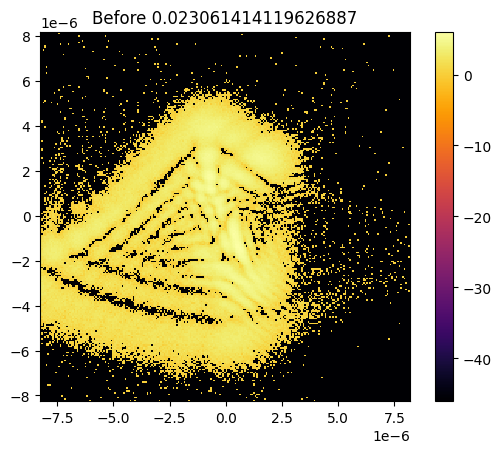

cuda


In [ ]:
e.set_random_dm(noise=1)

plt.title(f'Before {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
test_slope_standard = torch.tensor((e.get_slopes() - slopes_mean) / slopes_std, dtype=torch.float32).to('cpu')
test_slope_standard = test_slope_standard.reshape(1, -1)


#manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
#manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
#manual_test_torch = manual_test_torch.to(device)
# with torch.no_grad():
#     y_pred = model(test_slope_standard)

# e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)

# plt.title(f'After {e.get_strehl_ratio()}')
# image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

# imshow_field(image[0], cmap='inferno')
# plt.colorbar()
# plt.show()

C:\Users\alexe\AppData\Local\Temp\ipykernel_33628\3092388346.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  new_sets = np.array(y_pred[0].to('cpu')) * dm_std + dm_mean


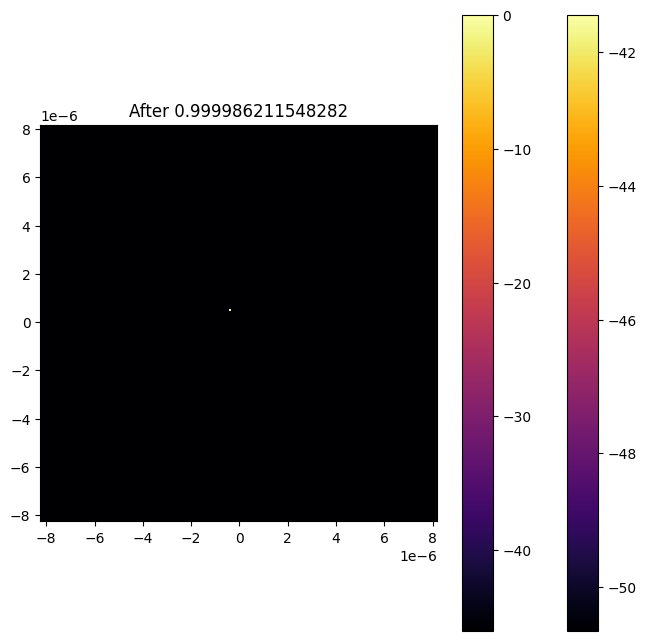

In [ ]:
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('Extreme noise neural net 10 modes correction.mp4', framerate=20)

for _ in range(350):
    test_slope_standard = torch.tensor((e.get_slopes() - slopes_mean) / slopes_std, dtype=torch.float32).to('cpu')
    test_slope_standard = test_slope_standard.reshape(1, -1)


    #manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
    #manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
    #manual_test_torch = manual_test_torch.to(device)
    with torch.no_grad():
        y_pred = model(test_slope_standard)
    
    new_sets = np.array(y_pred[0].to('cpu')) * dm_std + dm_mean
    alpha = 0.05
    new_sets = alpha * new_sets

    e.set_dm(new_sets)

    plt.clf()
    plt.title(f'After {e.get_strehl_ratio()}')
    image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]
    imshow_field(image[0], cmap='inferno')
    plt.colorbar()
    anim.add_frame()

plt.title(f'After {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()

anim.close()
plt.close()

In [ ]:
X_img = np.array([np.array(image) for image in images])
y = dm_settings_norm

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_img, y, test_size=0.2, random_state=42
)

In [ ]:
np.sqrt(57600)

np.float64(240.0)

In [ ]:
X_train_shaped = X_train.reshape((X_train.shape[0], 240, 240))
print(X_train_shaped.shape)

(4000, 240, 240)


In [ ]:
# Flatten X_train if needed (currently shape: (800, 2, 1849))
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize model, loss, and optimizer
model_img = LargeImageEncoderNet(output_dim=y_train.shape[1], input_shape=(X_train_shaped.shape[1], X_train_shaped.shape[2]))
criterion = nn.MSELoss()
optimizer = optim.Adam(model_img.parameters(), lr=1e-4)

In [ ]:
# Move model to the correct device (cuda or cpu) BEFORE creating optimizer
model_img.to(device)

# Move tensors to the correct device
X_train_tensor_device = X_train_tensor.to(device)
y_train_tensor_device = y_train_tensor.to(device)

# Re-create optimizer after moving model to device
optimizer = optim.Adam(model_img.parameters(), lr=1e-4)

# Training loop
epochs = 500
for epoch in range(epochs):
    model_img.train()
    optimizer.zero_grad()

    outputs = model_img(X_train_tensor_device)

    loss = criterion(outputs, y_train_tensor_device)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/500, Loss: 2.3398
Epoch 2/500, Loss: 695.8358
Epoch 3/500, Loss: 79.8791
Epoch 4/500, Loss: 62.2262
Epoch 5/500, Loss: 198.7472
Epoch 6/500, Loss: 166.9053
Epoch 7/500, Loss: 71.2814
Epoch 8/500, Loss: 14.4987
Epoch 9/500, Loss: 7.4986
Epoch 10/500, Loss: 24.5299
Epoch 11/500, Loss: 32.5762
Epoch 12/500, Loss: 25.7165
Epoch 13/500, Loss: 13.9138
Epoch 14/500, Loss: 5.0327
Epoch 15/500, Loss: 3.5698
Epoch 16/500, Loss: 7.7393
Epoch 17/500, Loss: 11.1799
Epoch 18/500, Loss: 10.2766
Epoch 19/500, Loss: 6.8566
Epoch 20/500, Loss: 3.6032
Epoch 21/500, Loss: 2.2697
Epoch 22/500, Loss: 2.7022
Epoch 23/500, Loss: 3.8722
Epoch 24/500, Loss: 4.4179
Epoch 25/500, Loss: 3.7088
Epoch 26/500, Loss: 2.4798
Epoch 27/500, Loss: 1.4263
Epoch 28/500, Loss: 1.2558
Epoch 29/500, Loss: 1.7093
Epoch 30/500, Loss: 2.1580
Epoch 31/500, Loss: 2.1221
Epoch 32/500, Loss: 1.6769
Epoch 33/500, Loss: 1.1555
Epoch 34/500, Loss: 0.8978
Epoch 35/500, Loss: 0.9950
Epoch 36/500, Loss: 1.2470
Epoch 37/500, Loss: 1

KeyboardInterrupt: 

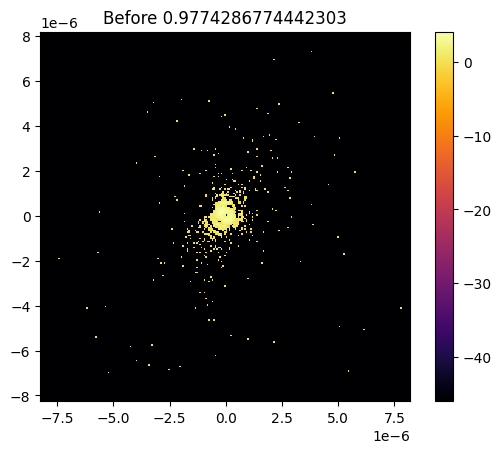

cuda


C:\Users\alexe\AppData\Local\Temp\ipykernel_33628\540595373.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)


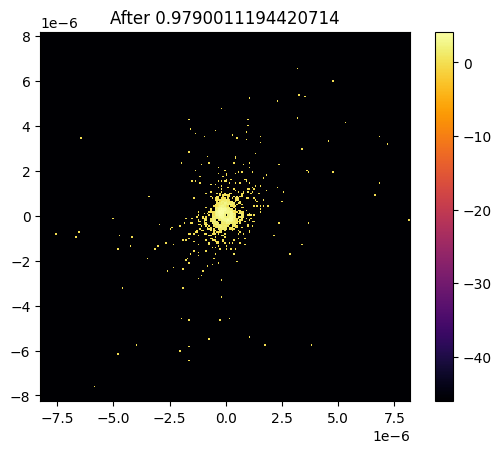

In [ ]:
e.set_random_dm(noise=0.01)

plt.title(f'Before {e.get_strehl_ratio()}')
image = np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))


imshow_field(image, cmap='inferno')
plt.colorbar()
plt.show()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

for _ in range(3):
    with torch.no_grad():
        y_pred = model_img(torch.tensor(image, dtype=torch.float32).to(device))

    e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)

    plt.title(f'After {e.get_strehl_ratio()}')
    image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()